In [1]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
import matplotlib.pyplot as plt

def integrated_oscillator(dt, num_steps, x0=0, y0=1, b0=0,angular_frequency=2*np.pi*1e-3):
    """
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float
        Initial values in three dimensional space.
    angular_frequency : float
        Angular frequency in 1/ms.

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t) + b0
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t) + b0
    return t, np.array((x, y))


def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep :
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).
        
    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.

    """

    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

def spiketrain_to_binary(spiketrain, t_start=None, t_stop=None, bin_size=0.001):
    """
    将neo.SpikeTrain对象转换为0-1序列
    
    Parameters
    ----------
    spiketrain : neo.SpikeTrain
        单个神经元的SpikeTrain对象
    t_start : float
        序列起始时间（秒），默认为spiketrain.t_start
    t_stop : float
        序列终止时间（秒），默认为spiketrain.t_stop
    bin_size : float
        时间bin的宽度，单位为秒，默认为1 ms（0.001s）

    Returns
    -------
    binary_array : np.ndarray
        长度为n_bins的01序列，表示每个bin是否有spike
    """
    if t_start is None:
        t_start = float(spiketrain.t_start.rescale('s'))
    if t_stop is None:
        t_stop = float(spiketrain.t_stop.rescale('s'))

    n_bins = int(np.ceil((t_stop - t_start) / bin_size))
    binary_array = np.zeros(n_bins, dtype=int)

    spike_times = spiketrain.rescale('s').magnitude
    # 计算spike所在的bin
    indices = ((spike_times - t_start) // bin_size).astype(int)
    # 剔除越界的spike
    indices = indices[(indices >= 0) & (indices < n_bins)]
    binary_array[indices] = 1

    return binary_array

In [2]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 1 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)
# set parameters for spike train generation
max_rate = 500 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run
# specify data size
num_trials = 10

In [3]:
num_spiketrains_list = [20, 15]
x0_list = [0,0]
y0_list = [1,2]
b0_list = [0,1]

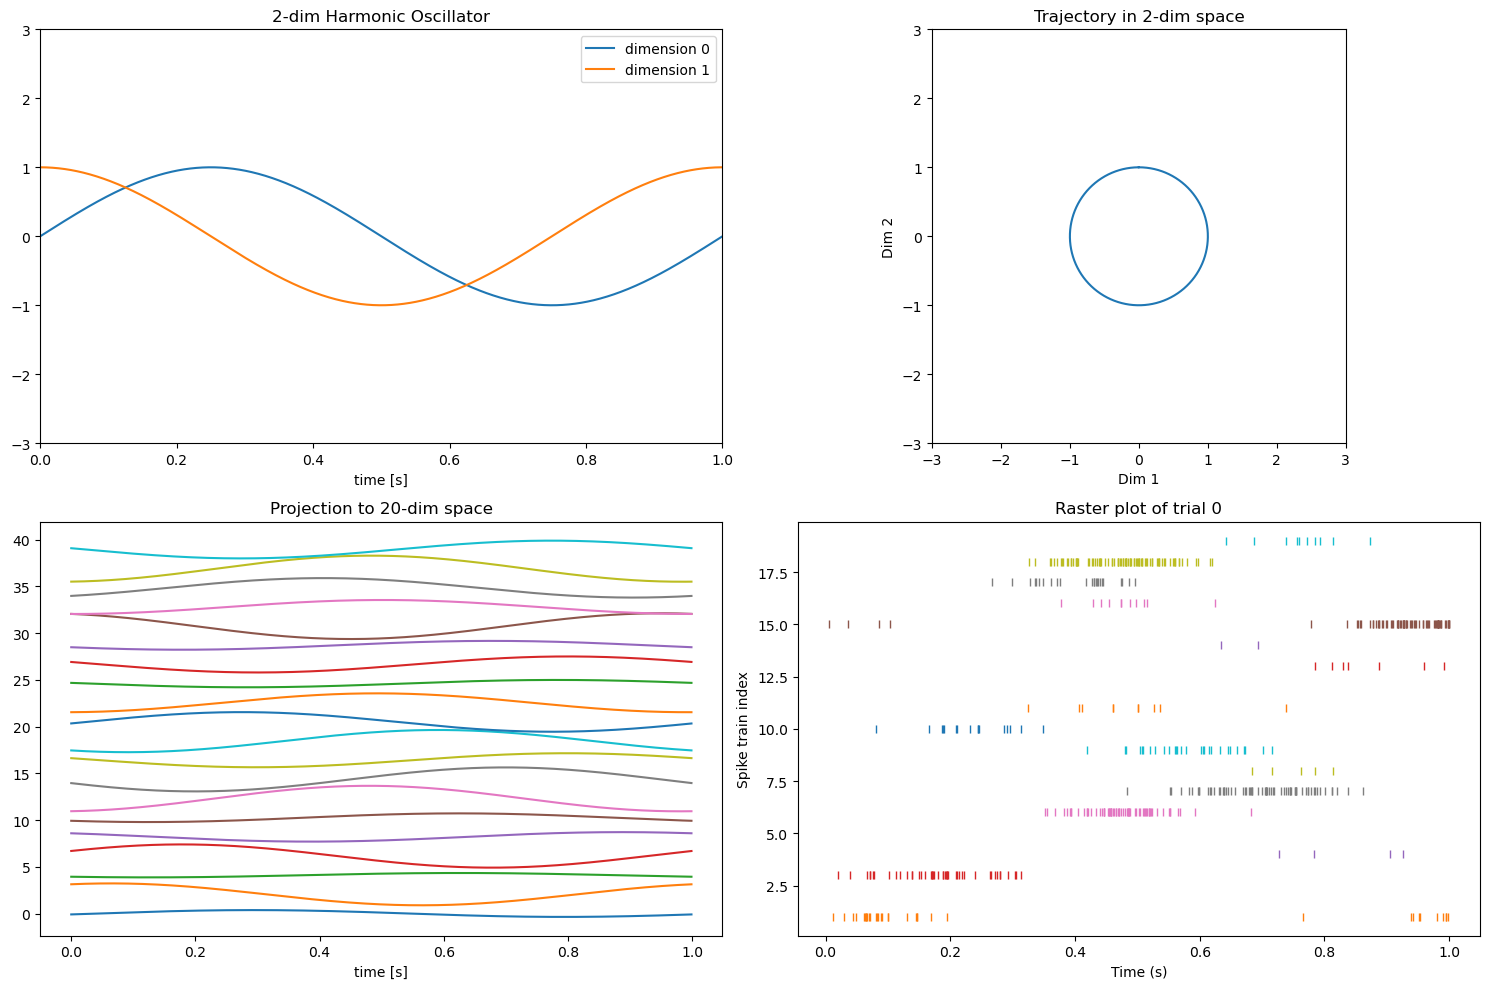

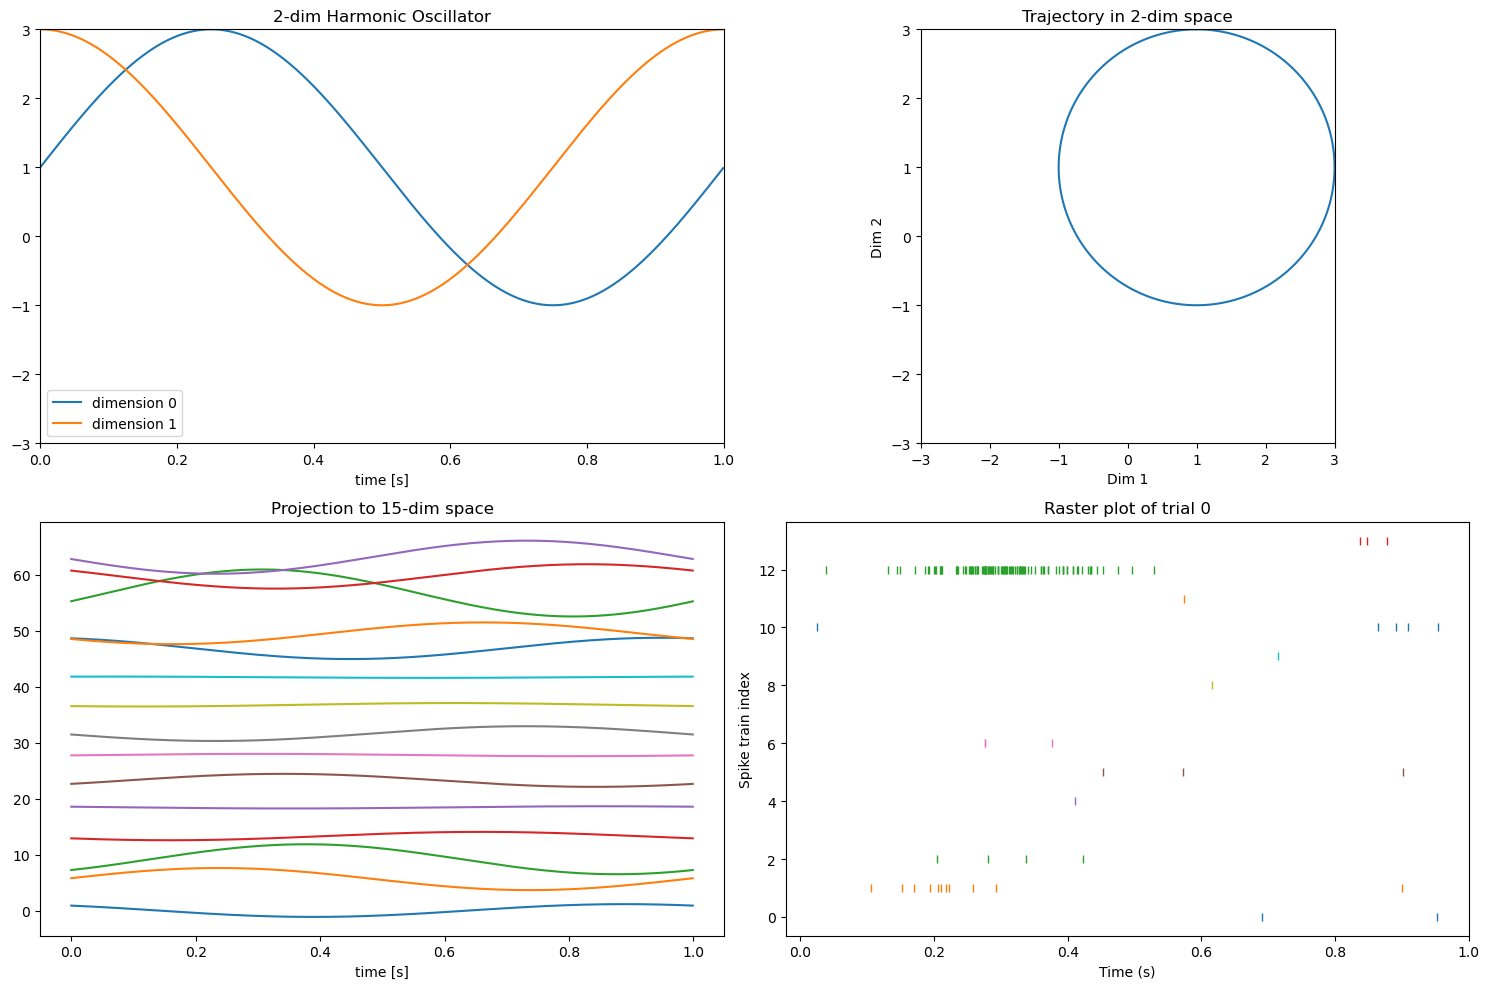

In [4]:
neo_spike_train_list = []

for m in range(len(num_spiketrains_list)):
    
    # generate a low-dimensional trajectory
    times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
        timestep.magnitude, num_steps=num_steps, x0=x0_list[m], y0=y0_list[m], b0=b0_list[m])
    times_oscillator = (times_oscillator*timestep.units).rescale('s')

    # random projection to high-dimensional space
    oscillator_trajectory_Ndim = random_projection(
        oscillator_trajectory_2dim, embedding_dimension=num_spiketrains_list[m])

    # convert to instantaneous rate for Poisson process
    normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
    instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

    # generate spike trains
    spiketrains_oscillator = generate_spiketrains(
        instantaneous_rates_oscillator, num_trials, timestep)
    neo_spike_train_list.append(spiketrains_oscillator)

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    ax1.set_title('2-dim Harmonic Oscillator')
    ax1.set_xlabel('time [s]')
    for i, y in enumerate(oscillator_trajectory_2dim):
        ax1.plot(times_oscillator, y, label=f'dimension {i}')
    ax1.legend()
    ax1.set_xlim(0,1)
    ax1.set_ylim(-3,3)

    ax2.set_title('Trajectory in 2-dim space')
    ax2.set_xlabel('Dim 1')
    ax2.set_ylabel('Dim 2')
    ax2.set_aspect(1)
    ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])
    ax2.set_xlim(-3,3)
    ax2.set_ylim(-3,3)

    ax3.set_title(f'Projection to {num_spiketrains_list[m]}-dim space')
    ax3.set_xlabel('time [s]')
    y_offset = oscillator_trajectory_Ndim.std() * 3
    for i, y in enumerate(oscillator_trajectory_Ndim):
        ax3.plot(times_oscillator, y + i*y_offset)

    trial_to_plot = 0
    ax4.set_title(f'Raster plot of trial {trial_to_plot}')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Spike train index')
    for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
        ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

    plt.tight_layout()
    plt.show()

In [5]:
multidays_spika_datas = []

for spiketrain in neo_spike_train_list:
    
    binary_spike_train = []
    
    for i in range(num_trials):
        
        binary_trial_spike_train = []
        for neuroni in range(len(spiketrain[i])):
            neuron_spike_train =  spiketrain[i][neuroni]
            neuron_spike_train = spiketrain_to_binary(neuron_spike_train, t_start=None, t_stop=None, bin_size=0.01)
            binary_trial_spike_train.append(neuron_spike_train)
        binary_trial_spike_train = np.asarray(binary_trial_spike_train) # neuron x time
            
        binary_spike_train.append(binary_trial_spike_train)
    
    binary_spike_train = np.asarray(binary_spike_train)
    
    multidays_spika_datas.append(binary_spike_train)

In [6]:
from linear_coupled_multi_GPFA import Multi_populations_GPFA
# from gpt import MultiPopulationsGPFA
import numpy as np

import torch
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [7]:
print(device)

cpu


In [8]:
multidays_spika_datas = [ torch.from_numpy(Xa.astype(float)).to(device) for Xa in multidays_spika_datas]

In [90]:
model = Multi_populations_GPFA(n_factors=2, T=1000, bin_width=0.01, tau=0.1, jitter=1e-6, 
                 beta=10, lamda=1, alpha=1, gamma=1, delta=5, min_rho_m=1e-1, min_sigma_m=1e-1, min_tau=0.1)
model.to(device)

# Initialize parameters if not done yet
model._initialize_parameters(multidays_spika_datas)

Xmi and Xmj fitting mse: 1.731338662080892e-16


In [91]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
# for name, param in model.named_parameters():
#     print(name, param.shape)
#     # print(param)     

iters = 100
for i in range(iters):
    opt.zero_grad()
    loss = model(multidays_spika_datas)
    # import pdb; pdb.set_trace()
    loss.backward()
    opt.step()
    if (i+1) % 10 == 0:
        print(f"iter {i+1:04d}  loss {loss.item():.2f}")

iter 0010  loss 98832.98
iter 0020  loss 92124.38
iter 0030  loss 85462.57
iter 0040  loss 78854.79
iter 0050  loss 72310.01
iter 0060  loss 65836.62
iter 0070  loss 59445.42
iter 0080  loss 53150.09
iter 0090  loss 46967.13
iter 0100  loss 40918.82


In [92]:
# for name, param in model.named_parameters():
#     print(name, param.shape)
#     print(param)     


In [93]:
model.A_mi_mj_0_1

Parameter containing:
tensor([[ 2.2445e-01, -3.8620e-05],
        [ 3.8620e-05,  2.2445e-01]], dtype=torch.float64, requires_grad=True)

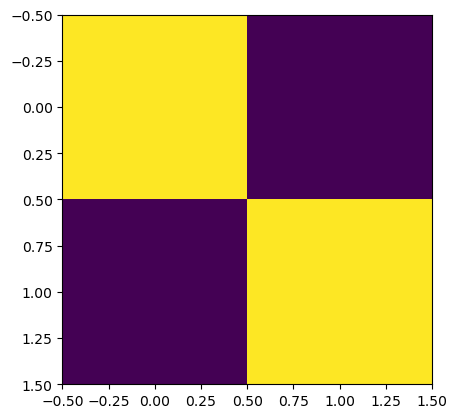

In [94]:
plt.imshow(model.A_mi_mj_0_1.detach().numpy())

In [95]:
model.b_mi_mj_0_1

Parameter containing:
tensor([-1.2143e-17,  3.4694e-18], dtype=torch.float64, requires_grad=True)

In [96]:
Xm_list = [model.Xm_0, model.Xm_1]
Xm_list = [Xm.detach().numpy() for Xm in Xm_list]

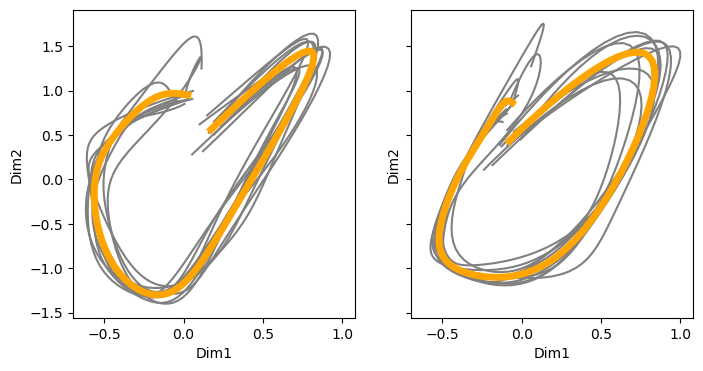

In [97]:
from scipy.ndimage import gaussian_filter1d
fig, axes = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
for m in range(len(Xm_list)):
    ax = axes[m]
    Xm = Xm_list[m]
    for i in range(num_trials):
        Xm_i = Xm[i]
        # smooth 
        sigma = 6
        x0_smooth = gaussian_filter1d(Xm_i[0], sigma=sigma)
        x1_smooth = gaussian_filter1d(Xm_i[1], sigma=sigma)
        ax.plot(x0_smooth, x1_smooth, color='grey')
    ax.plot(gaussian_filter1d(Xm.mean(0)[0], sigma=sigma),gaussian_filter1d(Xm.mean(0)[1], sigma=sigma), color='orange', lw=5 )
    ax.set_xlabel('Dim1')
    ax.set_ylabel('Dim2')
# plt.scatter(gaussian_filter1d(Xm.mean(0)[0], sigma=sigma).mean(), gaussian_filter1d(Xm.mean(0)[1], sigma=sigma).mean(), color='orange')